# Predator-Prey model with triangular transport map
Based on "Transport map accelerated Markov chain Monte Carlo" by Parno and Marzouk (SIAM/ASA Journal on Uncertainty Quantification 2018)

In [1]:
from collections import OrderedDict

# %env JAX_DEBUG_NANS=True
import jax
import jax.ops
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from functools import partial

import numpyro
from numpyro import distributions as dist
from numpyro.distributions.transforms import MultivariateAffineTransform
from numpyro.infer.guide import WrappedGuide
from numpyro.contrib.autoguide import AutoDelta
from numpyro.examples.runge_kutta import runge_kutta_4
from numpyro.infer import init_to_uniform, init_with_noise, SVI, Stein, ELBO
from numpyro.infer.kernels import RBFKernel
from numpyro.callbacks import Progbar
from numpyro.optim import Adam

/Users/asal/Documents/SourceControl/numpyro/numpyro/contrib/autoguide.py:9: FutureWarning: numpyro.contrib.autoguide has moved to numpyro.infer.autoguide. The contrib alias will stop working in future versions.
  warnings.warn("numpyro.contrib.autoguide has moved to numpyro.infer.autoguide. "


In [2]:
rng_key = jax.random.PRNGKey(242)

## Predator Prey Model

In [3]:
def predator_prey_step(t, state, r=0.6, k=100, s=1.2, a=25, u=0.5, v=0.3):
    prey = state[..., 0]
    predator = state[..., 1]
    sh = (prey * predator)/(a + prey + 1e-3)
    prey_upd = r * prey * (1 - prey / (k + 1e-3)) - s * sh
    predator_upd = u * sh - v * predator
    return jnp.stack((prey_upd, predator_upd), axis=-1)
num_time = 5
step_size = 0.1
num_steps = int(num_time / step_size)
dampening_rate = 0.9
lyapunov_scale = 1e-3
clip = lambda x: jnp.clip(x, -10.0, 10.0)
predator_prey = runge_kutta_4(predator_prey_step, step_size, num_steps, dampening_rate, 
                              lyapunov_scale, clip,
                              unconstrain_fn=lambda _, x: jnp.where(x < 10, jnp.log(jnp.expm1(x)), x),
                              constrain_fn=lambda _, x: jax.nn.softplus(x))
predator_prey = partial(predator_prey, rng_key)

In [4]:
indices = jnp.array([1, 11, 21, 31, 41])
res, lyapunov_loss = predator_prey(jnp.array([50., 5.]))
# res = np.reshape(res, (num_time, num_steps // num_time, -1))[:, 0, :]
noise = jax.random.normal(rng_key, (1000,5,2)) * 10
data = (indices, res[indices] + noise)
data

(DeviceArray([ 1, 11, 21, 31, 41], dtype=int32),
 DeviceArray([[[ 39.024734 , -12.725596 ],
               [ 66.321266 ,   6.9570694],
               [ 68.02709  ,   3.5552971],
               [ 91.41242  ,  12.742345 ],
               [ 72.7559   ,  -2.7840161]],
 
              [[ 70.52719  ,   8.503682 ],
               [ 82.815735 ,   7.1307344],
               [ 47.493027 ,  -3.0287352],
               [ 79.04639  ,  12.486196 ],
               [ 61.74772  ,   7.4273853]],
 
              [[ 44.77134  ,  -8.647642 ],
               [ 68.059166 ,  10.351532 ],
               [ 62.732346 ,  20.398567 ],
               [ 76.33949  ,  24.198376 ],
               [ 68.472824 ,  11.550084 ]],
 
              ...,
 
              [[ 65.18128  ,  17.313398 ],
               [ 62.665043 ,   5.9123344],
               [ 77.014946 ,   7.073232 ],
               [ 80.4568   ,  16.428682 ],
               [ 73.003334 ,   4.452607 ]],
 
              [[ 60.071377 ,  -6.5541363],
               

In [5]:
def model(indices, observations):
    prior_dist = dist.HalfNormal(1000)
    prey0 = numpyro.sample('prey0', prior_dist)
    predator0 = numpyro.sample('predator0', prior_dist)
    r = numpyro.sample('r', prior_dist)
    k = numpyro.sample('k', prior_dist)
    s = numpyro.sample('s', prior_dist)
    a = numpyro.sample('a', prior_dist)
    u = numpyro.sample('u', prior_dist)
    v = numpyro.sample('v', prior_dist)
    ppres, lyapunov_loss = predator_prey(jnp.array([prey0, predator0]), r=r, k=k, s=s, a=a, u=u, v=v)
    # ppres = np.reshape(ppres, (num_time, num_time // num_steps, -1))
    numpyro.factor('lyapunov_loss', lyapunov_loss)
    numpyro.sample('obs', dist.Normal(ppres[indices], 10.0).to_event(2), obs=observations)

### SVI

In [6]:
svi = SVI(model, AutoDelta(model), Adam(0.001), ELBO())
state = svi.init(rng_key, *data)
pbar = tqdm(range(1000))
for i in pbar:
    state, loss = svi.update(state, *data)
    pbar.set_description(f'SVI {loss}')

SVI nan: 100%|██████████| 1000/1000 [01:27<00:00, 11.40it/s]          


In [7]:
svi.get_params(state)

{'auto_a': DeviceArray(nan, dtype=float32),
 'auto_k': DeviceArray(nan, dtype=float32),
 'auto_predator0': DeviceArray(nan, dtype=float32),
 'auto_prey0': DeviceArray(nan, dtype=float32),
 'auto_r': DeviceArray(nan, dtype=float32),
 'auto_s': DeviceArray(nan, dtype=float32),
 'auto_u': DeviceArray(nan, dtype=float32),
 'auto_v': DeviceArray(nan, dtype=float32)}

### Guide and Stein with Transport Maps

In [8]:
svgd = Stein(model, AutoDelta(model),
             Adam(0.0001), ELBO(),
             RBFKernel(), num_particles=100,
             repulsion_temperature=0.001 * data[1].shape[0])
state, loss = svgd.train(rng_key, 10000, *data, callbacks=[Progbar()])  # rounds 10000

Stein nan: 100%|██████████| 10000/10000 [01:36<00:00, 104.03it/s]      


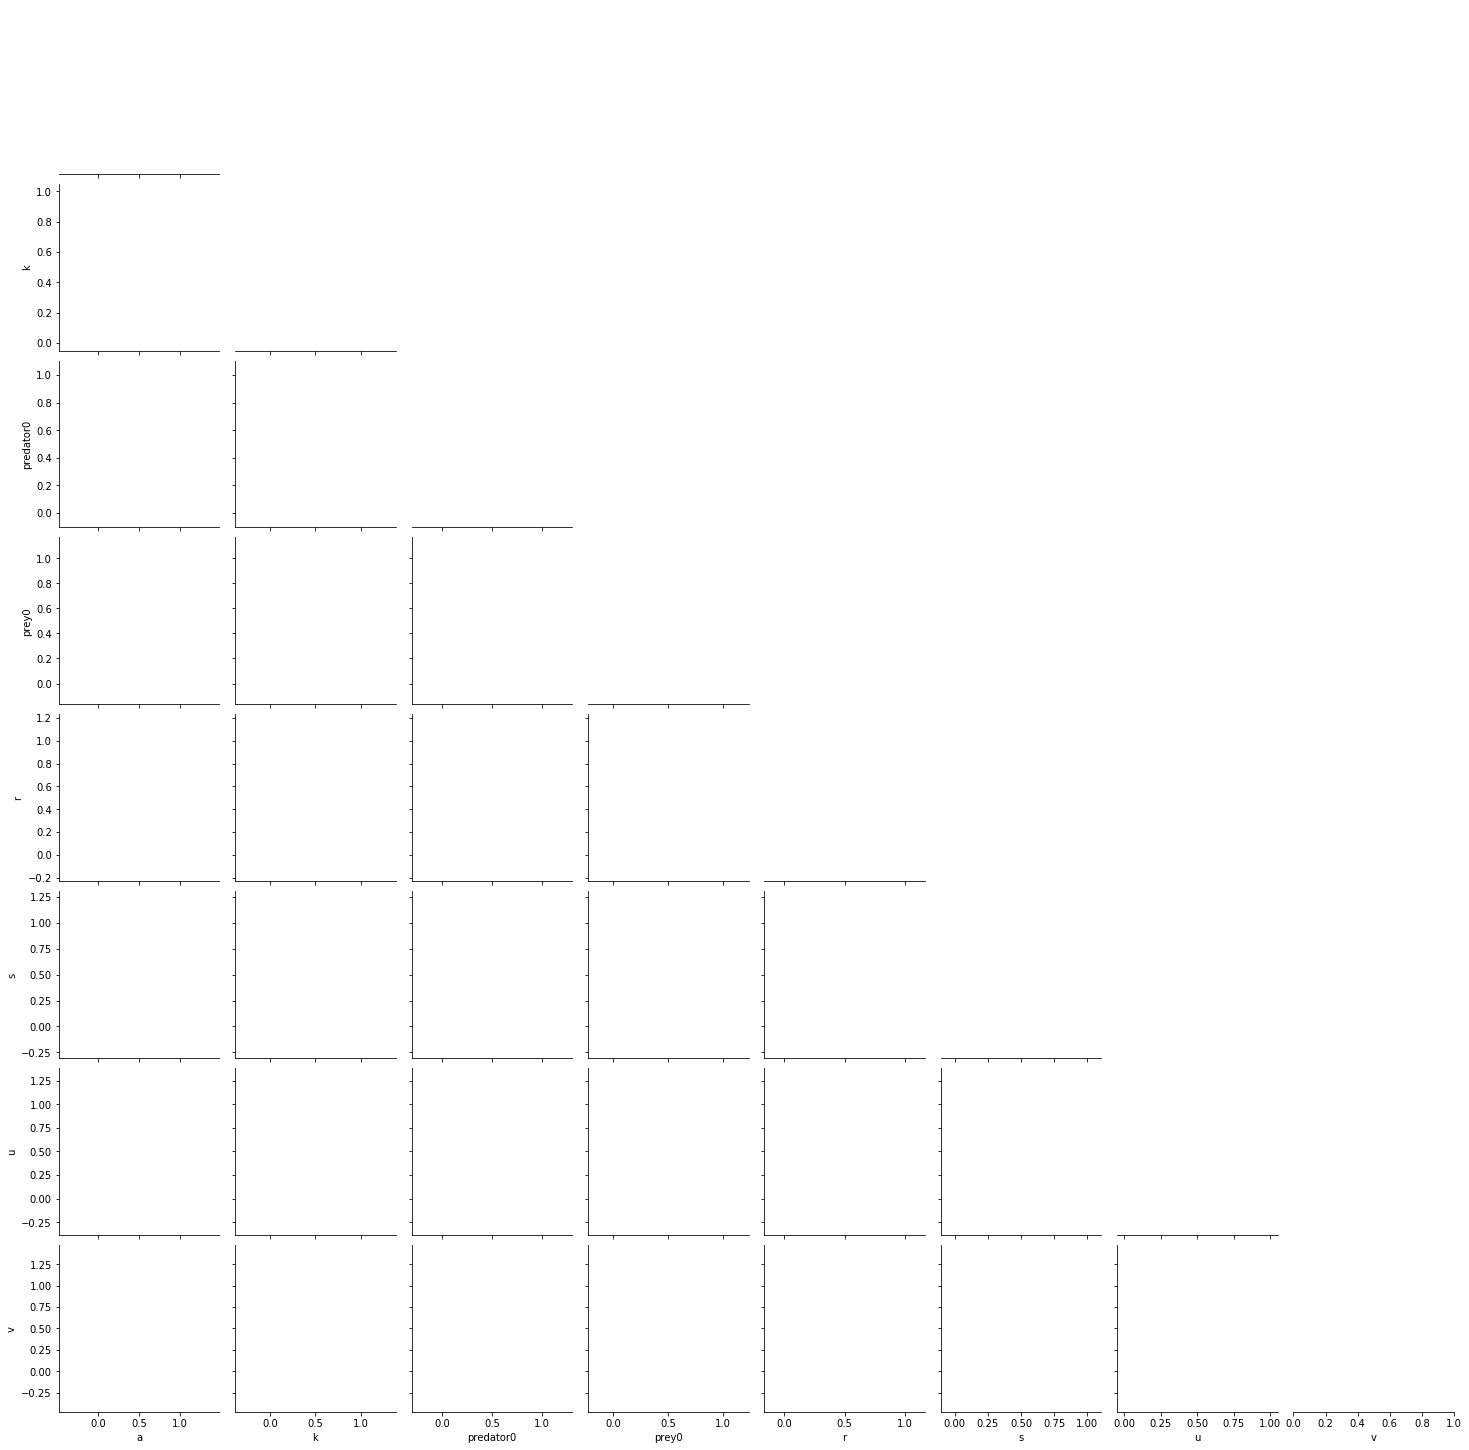

In [9]:
sample_frame = pd.DataFrame.from_dict(svgd.predict(state, *data))
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)

In [10]:
def transmap_guide(indices, observations):
    param_keys = {'prey0', 'preadtor0', 'r', 'k', 's', 'a', 'u', 'v'}
    n = len(param_keys)
    tmapp = numpyro.param('tmapp', jnp.zeros(n * (n + 1) // 2))
    tril_idx = jnp.tril_indices(n)
    tmap = jax.ops.index_update(jnp.zeros((n, n)), tril_idx, tmapp)
    tloc = numpyro.param('tloc', jnp.zeros(n))
    vals = numpyro.param('vals', jnp.zeros(n),
                         particle_transform=MultivariateAffineTransform(tloc, tmap),
                         constraint=dist.constraints.greater_than(0.1))
    for pk, val in zip(param_keys, vals):
        numpyro.sample(pk, dist.Delta(val))

In [ ]:
svgd = Stein(model, WrappedGuide(transmap_guide, init_strategy=init_with_noise(init_to_uniform())),
             Adam(0.01), ELBO(),
             RBFKernel(), repulsion_temperature=0.01 * data[1].shape[0],
             num_particles=100, classic_guide_params_fn=lambda n: n in {'tmapp', 'tloc'})
state, loss = svgd.train(rng_key, 10000, *data, callbacks=[Progbar()])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
sample_frame = pd.DataFrame(svgd.predict(state, *data))
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)

### NUTS MCMC Sampling

In [ ]:
mcmc = numpyro.infer.MCMC(numpyro.infer.NUTS(model), 100, 500, chain_method='vectorized')
mcmc.run(rng_key, *data)
mcmc.print_summary()

In [ ]:
samples = mcmc.get_samples()
sample_frame = pd.DataFrame(samples)
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)